<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

<Ответ> Можно. Можно применять подход c использованием кодирования слов, метод векторного представления слов. Каждое слово кодируется с помощью вектора фиксированной длины, равной количеству используемых слов в выборке. Можно использовать подход посимвольного кодирования (каждому символу будет сопоставлен вектор длины m элемент которого равен единице, в позиции равной порядковому номеру символа в алфавите, а нулю во всех остальных позициях). Из текста выбираются первые д символов. Но параметр l должен быть большим, чтобы в первых l символах содержалось достаточно информации для определения класса всего текста. Как правило, с этой задачей хорошо справляется RNN


**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

<Ответ> Все та же проблема затухающего градиента. В пределах одного предложения RNN будет работать неплохо, но если речь заходит о более длинном тексте, то закономерности в его начале уже не будут вносить какой либо вклад в решения сети ближе к концу текста, также как ошибка на первых элементах последовательностей в процессе обучения перестаёт вносить вклад в общую ошибку сети. Чтобы побороть этот недостаток, была придумана LSTM сеть, в которой были добавлены дополнительные внутренние преобразования, которые оперируют с памятью более осторожно. 

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

<Ответ> $\frac{d c_{n+1}}{d c_{n}} =  f_{n + 1}$ , $\frac{d c_{n+1}}{d c_{k}} =  \prod_{i = k + 1}^{n + 1}f_i $ В LSTM может контролировать затухание градиентов, контроль памяти через установку forget gate. Взрывается когда число больше 1. Можно использовать gradient clipping.

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

<Ответ> Мы суммируем вклады каждого шага времени в градиент. Другими словами, поскольку W используется на каждом шаге вплоть до вывода, о котором мы заботимся, нам нужно обратное перемещение градиентов от t = 3 по сети до t = 0. Развернутая повторяющаяся нейронная сеть для 5 временных шагов с градиентами. Это точно так же, как и стандартный алгоритм обратного распространения, который мы используем в глубоких нейронных сетях с прямой связью. Главное отличие состоит в том, что мы суммируем градиенты для W на каждом временном шаге. В традиционном NN мы не разделяем параметры по уровням, поэтому нам не нужно ничего суммировать.


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

<Ответ> Существует много задач, для решения которых удобно применять RNN в комбинации со сверточной сетью. Например, генерация описания изображения. Результат работы сверточной сети передается в RNN как нулевой hidden.

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

<Ответ> Слой Embedding занимается подготовкой фичей, параметры говорят о том, что в словаре n разных фичей, а сетке ждать последовательности из не более, чем m слов. Vocab_size - Размер нашего словаря. Embedding layer будет иметь форму [vocabulary_size, embedding_size].

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
# !wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
# !tar -xvzf data.tar.gz

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 8.51 s, sys: 6.97 s, total: 15.5 s
Wall time: 15.3 s


In [3]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [5]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
#word_counts = <here should be dict word:number of entrances>
word_counts = {}

for caption in captions:
    for line in caption:
        for word in line:
            word = word.encode('cp1251')
            if(word in word_counts):
                word_counts[str(word)] += 1
            else:
                word_counts[str(word)] = 1


vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [6]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [7]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [8]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [9]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [10]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [11]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
#l_word_embeddings = <Embedding Layer>
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)


In [12]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there

#l_image_features_small = <Apply Dropout Layer to regularise your Net>
l_image_features_small = DropoutLayer(l_image_features)
#l_image_features_small = <Apply Dense to acive LSTM_UNITS size of representation>
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [13]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 

# decoder = LSTMLayer(<Hmmm, what whould be here?>,
#                     num_units=LSTM_UNITS,
#                     cell_init=<Use your brain =)>,
#                     mask_input=<Mask?>,
#                     grad_clipping=<boom grads>)

decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=10**7)

In [14]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 200)
output shape =  (None, None, 10373)


In [15]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################

#loss = <mean over non-PAD tokens>
loss_out = output_mask * loss
loss = loss_out.sum() / output_mask.sum()

In [16]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################

# weights = <all dnn weigts>
# updates = <your favorite optimizer> 
weights = get_all_params(predicted_probabilities)
lr = 0.001
sh_lr = theano.shared(lasagne.utils.floatX(lr))
updates = lasagne.updates.adam(loss, weights, learning_rate=sh_lr)
#updates = lasagne.updates.momentum(loss, weights, learning_rate=0.1, momentum=0.9)

In [17]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################

# train_step = <>
# val_step   = 

train_step = theano.function([image_vectors, sentences], loss, updates=updates)
val_step   = theano.function([image_vectors, sentences], loss)

/opt/conda/envs/python2/lib/python2.7/site-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [18]:
captions = np.array(captions)

In [19]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [20]:
generate_batch(img_codes,captions, 3)

(array([[-5.82595825, -3.69038129, -2.62989855, ..., -2.88507533,
         -1.55520785,  0.26873717],
        [-2.69444346, -3.23652697, -4.807899  , ..., -2.4523263 ,
          3.40432453, -2.17504501],
        [-1.21019411, -0.23277046,  1.24703908, ..., -2.68118644,
          3.51874352,  2.14461708]], dtype=float32),
 array([[ 8481,  8717,   478,  4859,   389,  8602,  8902,   781,  8717,
          4817,  8134,    -1,    -1,    -1],
        [ 8481,  6766,  2665,  8861,  6424,  2853,  6766,  4888,  2773,
          8717,  7646,  8134,    -1,    -1],
        [ 8481,  8717,  4888, 10058,  8717,  8897,   326,  8717,  2099,
          5921,   781,  3323,  5822,  8134]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [21]:
batch_size = 50 #adjust me
n_epochs   = 100 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [ ]:
from tqdm import tqdm

for epoch in range(n_epochs):
    if epoch % 10 == 0 and epoch > 0:
        new_lr = sh_lr.get_value() / 2
        sh_lr.set_value(lasagne.utils.floatX(new_lr))
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 7.54025755903, val loss: 6.14922084812


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 5.78666734945, val loss: 5.60352889703


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 5.32279512227, val loss: 5.25464256322


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 5.08123703463, val loss: 5.0731304789


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 4.97690611629, val loss: 5.00186597637


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 4.85880373588, val loss: 4.74163802301


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 4.71250409589, val loss: 4.67996170987


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 4.60290019618, val loss: 4.57651279565


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 4.50599028852, val loss: 4.45227888225


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 4.4510642682, val loss: 4.40210607961


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.36047069642, val loss: 4.29837109701


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 4.28741174062, val loss: 4.25915970173


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 4.26223807191, val loss: 4.2566858754


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 4.19037575346, val loss: 4.17239795069


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 4.15885488168, val loss: 4.02860713169


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 4.11344247736, val loss: 4.09431612983


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 4.03391444981, val loss: 3.88264473745


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 4.01998685541, val loss: 4.01727577361


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 4.01823913032, val loss: 3.98782440735


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.91174653358, val loss: 3.88022334539


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 3.91282016178, val loss: 3.91201609888


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 3.87676534135, val loss: 3.80560620296


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 3.89168269854, val loss: 3.97633237692


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 3.87148614998, val loss: 3.70648033163


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 3.82852040279, val loss: 3.67831960001


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 3.7700605992, val loss: 3.79973474585


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 3.26172700975, val loss: 3.47231045828


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 3.26386751857, val loss: 3.21619183253


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 3.23962187914, val loss: 3.20879863963


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 3.29184206998, val loss: 3.291499806


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 3.28190526338, val loss: 3.20363871023


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 3.25092234909, val loss: 3.37506165083


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 3.21728588986, val loss: 3.17398670999


  4%|▍         | 2/50 [00:28<12:35, 15.74s/it]

KeyboardInterrupt: 

### apply trained model

In [23]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

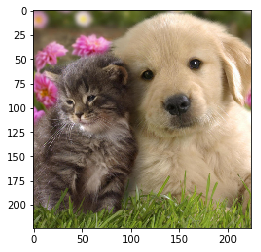

In [25]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [26]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [27]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a young cat sitting at a center container
a small brown cat lays inside of a mini church
apple takes the plate of a window
pictured a photo of a couple of apples with a basket
a spotted polar decorative gray cat on a beverage
a cat rests cases in a small open top
a zebra show in an open green chair
many adorable colored drivers sit in towels near a oxen setting
a cat eating its head in the water
stuffed plants are sitting on a couch in the black hilly sky


# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 